# 🧐
Google認為，一個優秀的開發人員，應該要可以對自己訓練出來的機器模型，回答幾個問題，像是
- 資料的變化會如何影響模型的預測？
- 機器模型對不同的群體有哪些不同的表現？
- 用來測試模型的資料是否足夠多樣化？

[Google釋出無程式碼機器學習模型分析工具](https://www.ithome.com.tw/news/125832)

Instead, good practitioners act as detectives, probing to understand their model better: 
- How would changes to a datapoint affect my model’s prediction? 
- Does it perform differently for various groups–for example, historically marginalized people? 
- How diverse is the dataset I am testing my model on?

[The What-If Tool: Code-Free Probing of Machine Learning Models](https://ai.googleblog.com/2018/09/the-what-if-tool-code-free-probing-of.html)

# An Example From RiskManagement

In [36]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [26]:
path = "/Users/soda/Documents/GitHub/riskmanagementnotes/dataset/data/"
raw_data = pd.read_csv(path+"Acard.txt")

In [27]:
raw_data.shape

(95806, 13)

In [28]:
np.unique(np.array(raw_data['obs_mth']))

array(['2018-06-30', '2018-07-31', '2018-09-30', '2018-10-31',
       '2018-11-30'], dtype=object)

In [34]:
feature_lst = ['person_info','finance_info','credit_info','act_info']

trn_x = raw_data.loc[raw_data.obs_mth != '2018-11-30',feature_lst].copy()
trn_y = raw_data.loc[raw_data.obs_mth != '2018-11-30','bad_ind'].copy()
vld_x = raw_data.loc[raw_data.obs_mth == '2018-11-30',feature_lst].copy()
vld_y = raw_data.loc[raw_data.obs_mth == '2018-11-30','bad_ind'].copy()

In [15]:
import xgboost as xgb

In [38]:
dtrain = xgb.DMatrix(trn_x,trn_y)
dvalid = xgb.DMatrix(vld_x,vld_y)
watchlist = [(dtrain,'train'),(dvalid,'eval')]

In [43]:
param = {'max_depth':2,'eta':1,'silent':1,
         'objective':'binary:logistic','eval_metric': 'auc'}
num_round = 10
bst = xgb.train(param,dtrain,num_round,watchlist)

[0]	train-auc:0.681722	eval-auc:0.671063
[1]	train-auc:0.740342	eval-auc:0.729295
[2]	train-auc:0.770689	eval-auc:0.746566
[3]	train-auc:0.795246	eval-auc:0.763697
[4]	train-auc:0.801214	eval-auc:0.767317
[5]	train-auc:0.809423	eval-auc:0.775835
[6]	train-auc:0.812139	eval-auc:0.775973
[7]	train-auc:0.812886	eval-auc:0.776707
[8]	train-auc:0.813262	eval-auc:0.780214
[9]	train-auc:0.813698	eval-auc:0.779042


In [54]:
y_hat = bst.predict(dvalid)
df = pd.DataFrame({'y_true':vld_y,'y_hat':y_hat})
threshold_20 = df['y_hat'].quantile(0.2)
df['pct_rank'] = df['y_hat'].map(lambda x:1 if x<=threshold_20 else 0)

In [62]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

fpr_top,tpr_top,_ = roc_curve(df.loc[df['pct_rank']==1,'y_true'],
                              df.loc[df['pct_rank']==1,'y_hat'])
fpr_,tpr_,_ = roc_curve(df['y_true'],df['y_hat'])

In [73]:
auc_top = round(auc(fpr_top, tpr_top),5)
auc_overall = round(auc(fpr_, tpr_),5)

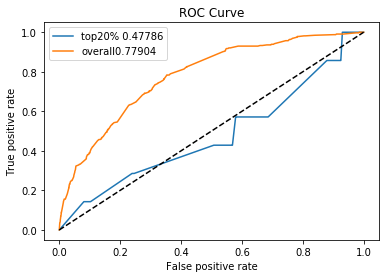

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(fpr_top,tpr_top,label = 'top20% '+str(auc_top))
plt.plot(fpr_,tpr_,label = 'overall'+ str(auc_overall))  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()

# Does it perform differently for various groups

In [77]:
def loglikehood(preds,dtrain):
    labels = dtrain.get_label()
    preds = 1.0/(1.0+np.exp(-preds))
    grad = preds - labels
    hess = preds*(1.0-preds)
    return grad,hess

In [82]:
def binary_error(preds, train_data):  
    labels = train_data.get_label()  
    dct = pd.DataFrame({'pred':preds,'percent':preds,'labels':labels})  
    key = dct['percent'].quantile(0.2)  
    dct['percent']= dct['percent'].map(lambda x :1 if x <= key else 0)    
    result = np.mean(dct[dct.percent== 1]['labels'] == 1)*0.5 \
               + np.mean((dct.labels - dct.pred)**2)*0.5  
    return 'error',result  

In [84]:
bst_cus =xgb.train(param,dtrain,num_round,watchlist,obj=loglikehood,
                  feval=binary_error)

[0]	train-auc:0.681722	eval-auc:0.671063	train-error:0.015926	eval-error:0.017703
[1]	train-auc:0.750515	eval-auc:0.746086	train-error:0.012648	eval-error:0.013458
[2]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012384	eval-error:0.013488
[3]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012427	eval-error:0.013542
[4]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012436	eval-error:0.013555
[5]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012438	eval-error:0.013558
[6]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012439	eval-error:0.013559
[7]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012439	eval-error:0.013559
[8]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012439	eval-error:0.013559
[9]	train-auc:0.763703	eval-auc:0.737026	train-error:0.012439	eval-error:0.013559


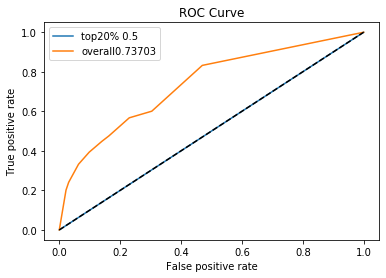

In [85]:
y_hat = bst_cus.predict(dvalid)
df_cus = pd.DataFrame({'y_true':vld_y,'y_hat':y_hat})
threshold_20 = df_cus['y_hat'].quantile(0.2)
df_cus['pct_rank'] = df_cus['y_hat'].map(lambda x:1 if x<=threshold_20 else 0)

fpr_top,tpr_top,_ = roc_curve(df_cus.loc[df_cus['pct_rank']==1,'y_true'],
                              df_cus.loc[df_cus['pct_rank']==1,'y_hat'])
fpr_,tpr_,_ = roc_curve(df_cus['y_true'],df_cus['y_hat'])
auc_top = round(auc(fpr_top, tpr_top),5)
auc_overall = round(auc(fpr_, tpr_),5)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(fpr_top,tpr_top,label = 'top20% '+str(auc_top))
plt.plot(fpr_,tpr_,label = 'overall'+ str(auc_overall))  
plt.plot([0,1],[0,1],'k--')  
plt.xlabel('False positive rate')  
plt.ylabel('True positive rate')  
plt.title('ROC Curve')  
plt.legend(loc = 'best')  
plt.show()

`reference`
1. https://www.jianshu.com/p/ac1c12f3fba1
2. https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

`Explainable Model`
1. I understand why
2. I understand why not
3. I know when you succeed
4. I know when you fail
5. I know when to trust you
6. I know why you erred
